<a href="https://colab.research.google.com/github/AzulBarr/Aprendizaje-Automatico/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aprendizaje-automatico-dc-uba-ar/material/blob/main/notebooks/notebook_08_descenso_gradiente-published.ipynb)

# Descenso por gradiente

Vamos a explorar el método de descenso por gradiente para el cómputo de una regresión lineal.


In [43]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from typing import Callable, Dict, Optional, Any
from sklearn.model_selection import GridSearchCV

#### Datos para trabajar

Tenemos los siguientes datos generados al azar para ser ajustados por una regresión.

In [44]:
bias = 500
X, y, coef = make_regression(n_samples=5000,
                             n_features=3,
                             bias= bias,
                             noise=1, random_state=42, coef=True)

print(f"Generamos una matriz de {X.shape[0]} de observaciones de {X.shape[1]} atributos\n" +
      f"Target en el rango {(round(min(y),2), round(max(y),2))}\n" +
      f"los coeficientes con los que fueron generados son: {coef}")

print(f"Y = {bias} + {' + '.join([str(round(c,2)) + ' * X' + str(idx+1) for idx,c in enumerate(coef)])} + ε")

Generamos una matriz de 5000 de observaciones de 3 atributos
Target en el rango (np.float64(113.11), np.float64(865.44))
los coeficientes con los que fueron generados son: [38.95952484  1.51074456 89.82730651]
Y = 500 + 38.96 * X1 + 1.51 * X2 + 89.83 * X3 + ε


Los datos se ven así:

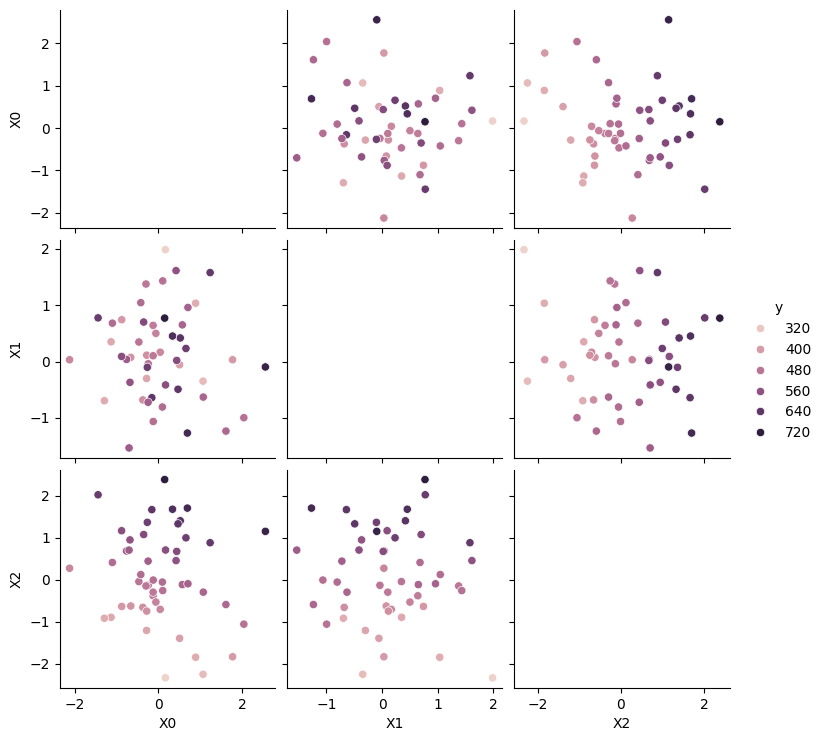

In [45]:
df = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
df["y"] = y
sns.pairplot(df.sample(50), hue="y")

En este notebook vamos a ver el resultado calculado de diversas formas, por lo que vamos a guardar para cada resultado los w y un valor de error.

In [46]:
# Usamos esta métrica, pero podemos reemplazarla por otra

def error_prediccion(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    # agrego columna para el intercept
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))

    predicciones = np.dot(X_ext, w)

    return mean_squared_error(predicciones, y)

Los resultados los almacenaremos en un `DataFrame`.

In [70]:
# Guardo los datos para comparaciones posteriores
resultados = pd.DataFrame(columns=["metodo", "w0", "w1", "w2", "w3", "error_prediccion"])

err = error_prediccion(X, y, np.array([bias] + list(coef)))
resultados.loc[len(resultados)] = ["simulacion", bias] + list(coef) + [err]
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500,38.959525,1.510745,89.827307,1.001549


## Descenso por gradiente

Veamos ahora la función general

In [48]:
def descenso_gradiente(g, dg, z_init, alpha, num_iterations, tol, verbose=False):
    """
    Descenso de gradiente para minimizar g.
    Args:
        g: La función a optimizar.
        dg: El gradiente de la función.
        z_init: Valor inicial.
        alpha: El 'learning rate'.
        num_iterations: Máx iteraciones.
        tol: Tolerancia para la convergencia.
    """
    z = z_init
    for _ in range(num_iterations):
        gradient = dg(z) # gradient vale por ej <0.5, -0.2, -3, 0>
        z_new = z - (alpha * gradient)
        if abs(g(z_new) - g(z)) < tol:
            break
        z = z_new
    return z


Con esto es todo lo que necesitamos de descenso por gradiente.

## Regresión lineal

Podemos generarnos una clase que calcula la regresión lineal utilizando el método de  descenso por gradiente y nos devuelva los pesos correspondientes a los w de la regresión.



In [56]:
from sklearn import preprocessing
from functools import partial
from sklearn.metrics import mean_squared_error
import numpy as np

class RegresionLinealDG():

    def __init__(self,
                 func_costo: Callable[..., float],
                 func_costo_grad: Callable[..., np.ndarray],
                 descenso_gradiente_hyperparams: Optional[Dict[str, Any]] = None,
                 batch_size: Optional[int] = None):
        self.func_costo = func_costo
        self.func_costo_grad = func_costo_grad
        self.descenso_gradiente_hyperparams = descenso_gradiente_hyperparams
        self.collect_info = False
        self.w = None
        self.batch_size = batch_size # Add batch_size parameter

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # agrego columna para el intercept
        col_ones = np.ones((X.shape[0], 1))
        X_ext = np.hstack((col_ones, X))

        n_samples = X_ext.shape[0]
        w_shape = X_ext.shape[1]
        z = np.zeros(w_shape) # Initialize weights

        num_iterations = self.descenso_gradiente_hyperparams.get("num_iterations", 1000)
        alpha = self.descenso_gradiente_hyperparams.get("alpha", 0.01)
        tol = self.descenso_gradiente_hyperparams.get("tol", 0.01)

        if self.batch_size is None or self.batch_size >= n_samples:
            # Full batch gradient descent
            cost_X_y = partial(self.func_costo, X=X_ext, y=y)
            grad_cost_X_y = partial(self.func_costo_grad, X=X_ext, y=y)
            self.w = descenso_gradiente(cost_X_y, grad_cost_X_y,
                                        z_init=z,
                                        alpha=alpha,
                                        num_iterations=num_iterations,
                                        tol=tol)
        else:
            # Mini-batch gradient descent
            # Define cost_X_y for convergence check in mini-batch
            cost_X_y = partial(self.func_costo, X=X_ext, y=y)
            z_prev = np.copy(z) # Store initial weights for the first convergence check

            for i in range(num_iterations): # num_iterations now represents epochs
                # Shuffle data for each epoch
                indices = np.random.permutation(n_samples)
                X_shuffled = X_ext[indices]
                y_shuffled = y[indices]

                for j in range(0, n_samples, self.batch_size):
                    X_batch = X_shuffled[j:j + self.batch_size]
                    y_batch = y_shuffled[j:j + self.batch_size]

                    # Calculate gradient for the current batch
                    grad_cost_batch = partial(self.func_costo_grad, X=X_batch, y=y_batch)
                    gradient = grad_cost_batch(z)

                    # Update weights
                    z = z - (alpha * gradient)

                # Check convergence per epoch using full dataset cost
                cost_full_current = cost_X_y(z)
                if abs(cost_full_current - cost_X_y(z_prev)) < tol:
                    if self.descenso_gradiente_hyperparams.get("verbose"):
                        print(f"Converged after {i+1} epochs.")
                    break
                z_prev = np.copy(z) # Store weights for the next epoch's convergence check


            self.w = z # Final weights after all epochs and batches

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.w is None:
            raise RuntimeError("Model has not been fitted yet.")
        col_ones = np.ones((X.shape[0], 1))
        X_ext = np.hstack((col_ones, X))
        return X_ext @ self.w

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        # Returns negative mean squared error for consistency with GridSearchCV
        return -mean_squared_error(y, self.predict(X))

Con la clase `RegresionLinealDG` ya debemos definir en la creación la función de costo y el gradiente que se utilizan en el método (descenso por grandiente).

Empecemos usando MSE:

$MSE_{X,y} = \frac{1}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)})^2$

y su gradiente:

$\nabla_{\mathbf{w}} MSE_{X,y}(w) = \frac{2}{n} \sum_{i=1}^{n} (\hat{h}_{w_0,w_1,\ldots,w_p}(x^{(i)}) - y^{(i)}) * x^{(i)}$



In [57]:
def mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    y_preds = X @ w
    return (1/len(y)) * np.sum((y_preds - y)**2)

def grad_mse(w: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    y_preds = X @ w
    return (2 / len(y)) * X.T @ (y_preds - y)

Podemos entonces crear nuestra regresión:

In [62]:
hyperparametros = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}

reg = RegresionLinealDG(mse, grad_mse, hyperparametros)#, batch_size = 500)

Entrenarla:

In [63]:
reg.fit(X,y)

Y obtener los w

In [64]:
print("(DescensoG) w", reg.w.round(1))

err = error_prediccion(X, y, reg.w)
resultados.loc[len(resultados)] = [f"DescensoGradiente {hyperparametros['num_iterations']}"] + list(reg.w) + [err]

(DescensoG) w [499.9  39.    1.5  89.8]


In [65]:
resultados

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
2,DescensoGradiente 1000,499.531213,38.904996,1.488644,89.716010,1.252022
3,DescensoGradiente 1000,499.893883,38.950701,1.479364,89.788632,1.016532


## Solución analítica

Analogamente, podemos computar el valor analitico de los _w_ con la fórmula:

$w = (X^T X)^{-1} X^T y$

In [67]:
from numpy.linalg import inv

def minimizacion_analitica(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    col_ones = np.ones((X.shape[0], 1))
    X_ext = np.hstack((col_ones, X))
    X_XT_inv = inv(X_ext.T @ X_ext)
    w_analitico = (X_XT_inv @ X_ext.T) @ y

    return w_analitico

Calculemos los w:

In [68]:
w_analitico = minimizacion_analitica(X, y)
print("(Analítico) w", w_analitico.round(1))

err = error_prediccion(X, y, w_analitico)
resultados.loc[len(resultados)] = [f"Analítico"] + list(w_analitico) + [err]
resultados

(Analítico) w [500.   39.    1.5  89.8]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,Analítico,500.019873,38.968244,1.475379,89.815231,0.999661


# Ejercicios

1. Realizar una grilla para los hyperparámetros de la regresión:

    `{"alpha": 0.01, "num_iterations": 1000, "tol": 0.01}`
    
    y reportar su comportamiento.

1. Implementar y experimentar el comportamiento con otra función de costo en lugar de MSE, elegir al menos una entre:
    - MSE_Ridge
    - MSE_Lasso
    - MSE_ElasticSearch
    
   Reportar los resultados en el DataFrame.
1. Modificar `RegresionLinealDG` para que realice mini-batch y verificar el funcionamiento comparando con el punto 1.


Let's implement the MSE with Ridge regularization and its gradient.

In [77]:
from itertools import product

hiperparametros = {"alpha": [0.01, 0.1], # Reduced alpha values to prevent divergence
                   "num_iterations": [100, 1000, 10000],
                   "tol": [0.01, 0.05, 0.1]}

# Get all combinations of hyperparameters
keys, values = zip(*hiperparametros.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in product(*values)]

for params in hyperparameter_combinations:
    print(f"Training with parameters: {params}")
    reg = RegresionLinealDG(mse, grad_mse, params, batch_size=5000)
    reg.fit(X, y)

    # Check if weights contain NaN or inf values
    if np.isnan(reg.w).any() or np.isinf(reg.w).any():
        print(f"Skipping parameters {params} due to NaN or Inf in weights.")
        continue # Skip to the next iteration

    err = error_prediccion(X, y, reg.w)

    # Store the results
    # Ensure the number of columns matches the DataFrame structure
    row_data = [f"DescensoGradiente {params}"] + list(reg.w) + [err]
    resultados.loc[len(resultados)] = row_data

display(resultados)

Training with parameters: {'alpha': 0.01, 'num_iterations': 100, 'tol': 0.01}
Training with parameters: {'alpha': 0.01, 'num_iterations': 100, 'tol': 0.05}
Training with parameters: {'alpha': 0.01, 'num_iterations': 100, 'tol': 0.1}
Training with parameters: {'alpha': 0.01, 'num_iterations': 1000, 'tol': 0.01}
Training with parameters: {'alpha': 0.01, 'num_iterations': 1000, 'tol': 0.05}
Training with parameters: {'alpha': 0.01, 'num_iterations': 1000, 'tol': 0.1}
Training with parameters: {'alpha': 0.01, 'num_iterations': 10000, 'tol': 0.01}
Training with parameters: {'alpha': 0.01, 'num_iterations': 10000, 'tol': 0.05}
Training with parameters: {'alpha': 0.01, 'num_iterations': 10000, 'tol': 0.1}
Training with parameters: {'alpha': 0.1, 'num_iterations': 100, 'tol': 0.01}
Training with parameters: {'alpha': 0.1, 'num_iterations': 100, 'tol': 0.05}
Training with parameters: {'alpha': 0.1, 'num_iterations': 100, 'tol': 0.1}
Training with parameters: {'alpha': 0.1, 'num_iterations': 100

,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
2,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
3,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
4,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",499.531213,38.904996,1.488644,89.716010,1.252022
...,...,...,...,...,...,...
176,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.703368,38.924247,1.485518,89.749272,1.106014
177,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.525316,38.901420,1.490283,89.713298,1.258832
178,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.890241,38.949202,1.480012,89.787593,1.017574
179,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.703368,38.924247,1.485518,89.749272,1.106014


Let's compare the weights found using Gradient Descent with a batch size of 1 (Stochastic Gradient Descent) and with mini-batches of 10% of the dataset size.

In [78]:
# Define hyperparameters (can use the same as previous experiments)
hyperparametros_sgd = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01} # Adjust num_iterations and alpha if needed for convergence with SGD

# Run with batch size = 1 (Stochastic Gradient Descent)
print("Training with Batch Size = 1 (SGD)")
reg_sgd = RegresionLinealDG(mse, grad_mse, hyperparametros_sgd, batch_size=1)
reg_sgd.fit(X, y)
w_sgd = reg_sgd.w
print("(SGD) w:", w_sgd.round(2))

# Calculate error and store results
err_sgd = error_prediccion(X, y, w_sgd)
resultados.loc[len(resultados)] = [f"DescensoGradiente SGD"] + list(w_sgd) + [err_sgd]

# Define mini-batch size (10% of dataset size)
dataset_size = X.shape[0]
mini_batch_size = int(dataset_size * 0.1)
if mini_batch_size == 0:
    mini_batch_size = 1 # Ensure batch size is at least 1
print(f"\nTraining with Mini-Batch Size = {mini_batch_size} (10% of dataset)")

# Define hyperparameters (can use the same as previous experiments or adjust for mini-batch)
hyperparametros_mini_batch_10_percent = {"alpha": 0.01, "num_iterations": 1000, "tol": 0.01} # Adjust num_iterations and alpha if needed

# Run with mini-batch size of 10%
reg_mini_batch_10_percent = RegresionLinealDG(mse, grad_mse, hyperparametros_mini_batch_10_percent, batch_size=mini_batch_size)
reg_mini_batch_10_percent.fit(X, y)
w_mini_batch_10_percent = reg_mini_batch_10_percent.w
print(f"(Mini-Batch {mini_batch_size}) w:", w_mini_batch_10_percent.round(2))

# Calculate error and store results
err_mini_batch_10_percent = error_prediccion(X, y, w_mini_batch_10_percent)
resultados.loc[len(resultados)] = [f"DescensoGradiente Mini-Batch ({mini_batch_size})"] + list(w_mini_batch_10_percent) + [err_mini_batch_10_percent]

display(resultados)

Training with Batch Size = 1 (SGD)
(SGD) w: [499.95  38.88   1.4   89.8 ]

Training with Mini-Batch Size = 500 (10% of dataset)
(Mini-Batch 500) w: [499.89  38.95   1.48  89.79]


,metodo,w0,w1,w2,w3,error_prediccion
0,simulacion,500.000000,38.959525,1.510745,89.827307,1.001549
1,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
2,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
3,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",433.738944,32.833456,1.900621,77.547557,4577.955785
4,"DescensoGradiente {'alpha': 0.01, 'num_iterati...",499.531213,38.904996,1.488644,89.716010,1.252022
...,...,...,...,...,...,...
178,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.890241,38.949202,1.480012,89.787593,1.017574
179,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.703368,38.924247,1.485518,89.749272,1.106014
180,"DescensoGradiente {'alpha': 0.1, 'num_iteratio...",499.525316,38.901420,1.490283,89.713298,1.258832
181,DescensoGradiente SGD,499.952495,38.883343,1.403529,89.803511,1.016715
